Загружаем датасет

In [ ]:
import json

data = []

with open('train.json', 'r', encoding='utf-8') as f:
  for line in f:
    obj = json.loads(line.strip())
    data.append(obj)

In [ ]:
with open('test.json', 'r', encoding='utf-8') as f:
  for line in f:
    obj = json.loads(line.strip())
    data.append(obj)

In [ ]:
with open('train(1).json', 'r', encoding='utf-8') as f:
  for line in f:
    obj = json.loads(line.strip())
    data.append(obj)

In [ ]:
with open('test(1).json', 'r', encoding='utf-8') as f:
  for line in f:
    obj = json.loads(line.strip())
    data.append(obj)

In [ ]:
data

[{'source': 'очень классная тетка ктобы что не говорил.',
  'correction': 'очень классная тетка кто бы что ни говорил',
  'domain': 'RUSpellRU'},
 {'source': 'Может выгоднее втулку продать и купить колесо в сборе?',
  'correction': 'Может выгоднее втулку продать и купить колесо в сборе',
  'domain': 'RUSpellRU'},
 {'source': 'Довольно большая часть пришедших сходила с дорожек и усаживалась на траву.',
  'correction': 'Довольно большая часть пришедших сходила с дорожек и усаживалась на траву',
  'domain': 'RUSpellRU'},
 {'source': 'Симпатичнейшое шпионское устройство, такой себе гламурный фотоаппарат девушки Бонда - миниатюрная модель камеры Superheadz Clap Camera.',
  'correction': 'Симпатичнейшее шпионское устройство такой себе гламурный фотоаппарат девушки Бонда миниатюрная модель камеры Superheadz Clap Camera',
  'domain': 'RUSpellRU'},
 {'source': 'Опофеозом дня для меня сегодня стала фраза услышанная в новостях:',
  'correction': 'Апофеозом дня для меня сегодня стала фраза услышан

In [ ]:
import pandas as pd

df = pd.DataFrame([{'source': item['source'], 'correction': item['correction']} for item in data])
df

,source,correction
0,очень классная тетка ктобы что не говорил.,очень классная тетка кто бы что ни говорил
1,Может выгоднее втулку продать и купить колесо ...,Может выгоднее втулку продать и купить колесо ...
2,Довольно большая часть пришедших сходила с дор...,Довольно большая часть пришедших сходила с дор...
3,"Симпатичнейшое шпионское устройство, такой себ...",Симпатичнейшее шпионское устройство такой себе...
4,Опофеозом дня для меня сегодня стала фраза усл...,Апофеозом дня для меня сегодня стала фраза усл...
...,...,...
11681,"Отличный теплый свитер, состав - 55 хлопка и 4...","Отличный теплый свитер, состав - 55 хлопка и 4..."
11682,"Бомбовские штаны! на 75х105, ляха 65 элька сел...","Бомбовские штаны! на 75х105, ляха 65 элька сел..."
11683,"заказ 13 октября, получила 16 ноября, трек отс...","заказ 13 октября, получила 16 ноября, трек отс..."
11684,"Кофта хорошая. Но, это совсем не то, что у про...","Кофта хорошая. Но, это совсем не то, что у про..."


In [ ]:
df.isna().sum()

,0
source,0
correction,0


Пропусков нет

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11686 entries, 0 to 11685
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   source      11686 non-null  object
 1   correction  11686 non-null  object
dtypes: object(2)
memory usage: 182.7+ KB


все признаки являются строками

In [ ]:
df.describe()

,source,correction
count,11686,11686
unique,11675,11672
top,Seller shall scrutinize the terms of delivery ...,Seller shall scrutinize the terms of delivery ...
freq,3,3


In [ ]:
pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.7 MB/s eta 0:00:00


Загружаем необходимые библиотеки

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import random
from jiwer import cer, wer
import numpy as np

Создаём словарь с токенами

In [ ]:
chars = set()
for text in df['correction'] + df['source']:
    chars.update(text)

char_to_idx = {c:i+4 for i,c in enumerate(chars)}
char_to_idx.update({'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3})
idx_to_char = {v:k for k,v in char_to_idx.items()}
vocab_size = len(char_to_idx)

Напишем класс кастомного датасета и функцию приведения строк к единой длине

In [ ]:
class TypoDataset(Dataset):
    def __init__(self, df, char_to_idx):
        self.data = []
        for _, row in df.iterrows():
            src = [char_to_idx.get(c, char_to_idx['<UNK>']) for c in row['source']]
            trg = [char_to_idx.get(c, char_to_idx['<UNK>']) for c in row['correction']]
            self.data.append((
                torch.tensor([char_to_idx['<SOS>']] + src + [char_to_idx['<EOS>']], dtype=torch.long),
                torch.tensor([char_to_idx['<SOS>']] + trg + [char_to_idx['<EOS>']], dtype=torch.long)
            ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    src, trg = zip(*batch)
    return (
        pad_sequence(src, padding_value=char_to_idx['<PAD>'], batch_first=True),
        pad_sequence(trg, padding_value=char_to_idx['<PAD>'], batch_first=True)
    )

Создадим даталоадеры

In [ ]:
dataset = TypoDataset(df, char_to_idx)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

Базовая seq2seq с RNN

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.RNN(emb_dim, hid_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        outputs = self.dropout(outputs)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.RNN(emb_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

функция обучения

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    enc, dec = model
    enc.train()
    dec.train()
    epoch_loss = 0

    for src, trg in iterator:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        encoder_outputs, hidden = enc(src)

        output = trg[:, 0]
        loss = 0

        for t in range(1, trg.shape[1]):
            output, hidden = dec(output, hidden)
            loss += criterion(output, trg[:, t])
            output = output.argmax(1)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(enc.parameters(), clip)
        torch.nn.utils.clip_grad_norm_(dec.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() / trg.shape[1]

    return epoch_loss / len(iterator)

функция оценки модели

In [ ]:
def evaluate(model, iterator, criterion):
    enc, dec = model
    enc.eval()
    dec.eval()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for src, trg in iterator:
            src, trg = src.to(device), trg.to(device)
            encoder_outputs, hidden = enc(src)

            output = trg[:, 0]
            preds = []

            for t in range(1, trg.shape[1]):
                output, hidden = dec(output, hidden)
                preds.append(output.argmax(1).cpu())
                output = output.argmax(1)

            preds = torch.stack(preds, 1)
            all_preds.extend(preds)
            all_targets.extend(trg[:, 1:].cpu())

    pred_texts = [' '.join([idx_to_char[int(i)] for i in seq if i not in {0,1,2,3}]) for seq in all_preds]
    target_texts = [' '.join([idx_to_char[int(i)] for i in seq if i not in {0,1,2,3}]) for seq in all_targets]

    cer_score = cer(target_texts, pred_texts)
    wer_score = wer(target_texts, pred_texts)

    return cer_score, wer_score

запускаем обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = Encoder(vocab_size, 256, 512).to(device)
dec = Decoder(vocab_size, 256, 512).to(device)
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()))
criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx['<PAD>'])

N_EPOCHS = 10
CLIP = 1.0
train_losses = []
val_cer_scores = []
val_wer_scores = []

for epoch in range(N_EPOCHS):
    train_loss = train((enc, dec), train_loader, optimizer, criterion, CLIP)
    val_cer, val_wer = evaluate((enc, dec), val_loader, criterion)

    train_losses.append(train_loss)
    val_cer_scores.append(val_cer)
    val_wer_scores.append(val_wer)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val CER: {val_cer:.3f} | Val WER: {val_wer:.3f}')

Epoch: 01 | Train Loss: 3.392 | Val CER: 0.999 | Val WER: 0.998
Epoch: 02 | Train Loss: 3.369 | Val CER: 1.000 | Val WER: 0.999
Epoch: 03 | Train Loss: 3.370 | Val CER: 1.000 | Val WER: 0.999
Epoch: 04 | Train Loss: 3.365 | Val CER: 1.000 | Val WER: 1.000
Epoch: 05 | Train Loss: 3.367 | Val CER: 0.999 | Val WER: 0.998
Epoch: 06 | Train Loss: 3.374 | Val CER: 1.000 | Val WER: 0.999
Epoch: 07 | Train Loss: 3.372 | Val CER: 1.000 | Val WER: 1.000
Epoch: 08 | Train Loss: 3.371 | Val CER: 1.000 | Val WER: 0.999
Epoch: 09 | Train Loss: 3.371 | Val CER: 1.000 | Val WER: 0.999
Epoch: 10 | Train Loss: 3.367 | Val CER: 1.000 | Val WER: 0.999


Визуализируем полученную информацию

In [ ]:
best_rnn_loss = np.min(train_losses)
best_rnn_cer = np.min(val_cer_scores)
best_rnn_wer = np.min(val_wer_scores)

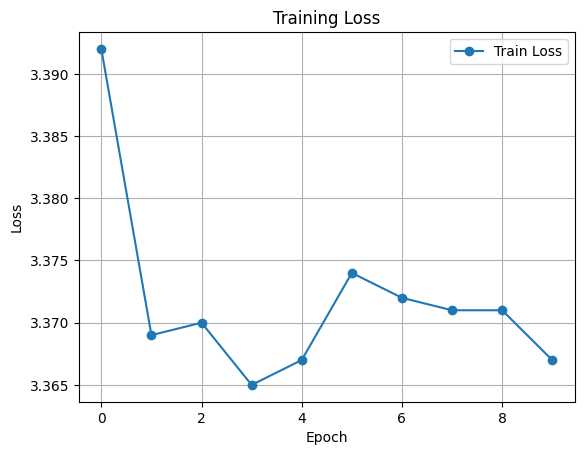

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Из графика ошибки видно, что есть небольшое улучшение, но потом ошибка выходит на плато и не уменьшается

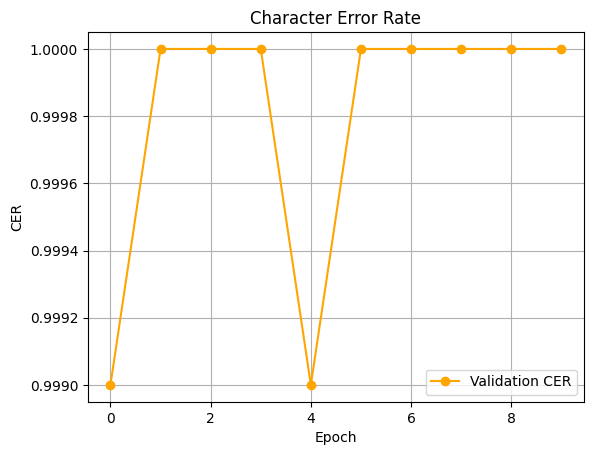

In [ ]:
plt.plot(val_cer_scores, label='Validation CER', color='orange', marker='o')
plt.title('Character Error Rate')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.grid(True)
plt.legend()
plt.show()

Из графика CER видно, что метрика колеблется на значениях 1 и 0,999, что означает что модель плохая и не обучается.

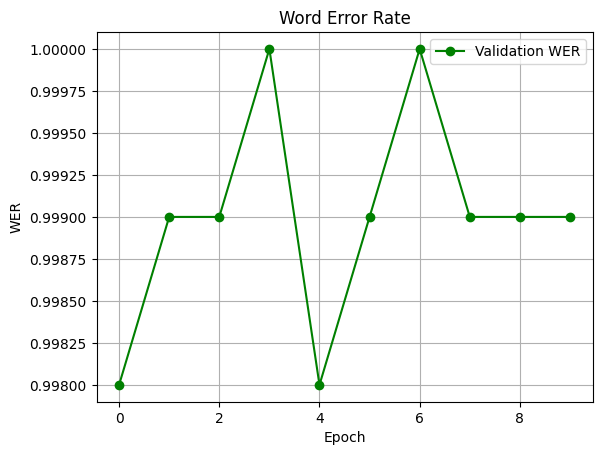

In [ ]:
plt.plot(val_wer_scores, label='Validation WER', color='green', marker='o')
plt.title('Word Error Rate')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.grid(True)
plt.legend()
plt.show()

График WER практически не отличается от графика CER и также показывает, что модель плохая.

Базовая seq2seq с LSTM

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        outputs = self.dropout(outputs)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

запускаем обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = Encoder(vocab_size, 256, 512).to(device)
dec = Decoder(vocab_size, 256, 512).to(device)
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()))
criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx['<PAD>'])

N_EPOCHS = 10
CLIP = 1.0
train_losses = []
val_cer_scores = []
val_wer_scores = []

for epoch in range(N_EPOCHS):
    train_loss = train((enc, dec), train_loader, optimizer, criterion, CLIP)
    val_cer, val_wer = evaluate((enc, dec), val_loader, criterion)

    train_losses.append(train_loss)
    val_cer_scores.append(val_cer)
    val_wer_scores.append(val_wer)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val CER: {val_cer:.3f} | Val WER: {val_wer:.3f}')

Epoch: 01 | Train Loss: 3.362 | Val CER: 1.000 | Val WER: 0.999
Epoch: 02 | Train Loss: 3.348 | Val CER: 1.000 | Val WER: 0.999
Epoch: 03 | Train Loss: 3.335 | Val CER: 1.000 | Val WER: 0.999
Epoch: 04 | Train Loss: 3.332 | Val CER: 0.999 | Val WER: 0.998
Epoch: 05 | Train Loss: 3.330 | Val CER: 1.000 | Val WER: 0.999
Epoch: 06 | Train Loss: 3.319 | Val CER: 0.873 | Val WER: 0.997
Epoch: 07 | Train Loss: 3.302 | Val CER: 0.798 | Val WER: 0.996
Epoch: 08 | Train Loss: 3.297 | Val CER: 0.792 | Val WER: 0.995
Epoch: 09 | Train Loss: 3.292 | Val CER: 0.792 | Val WER: 0.995
Epoch: 10 | Train Loss: 3.280 | Val CER: 0.791 | Val WER: 0.990


Визуализируем результаты

In [ ]:
best_lstm_loss = np.min(train_losses)
best_lstm_cer = np.min(val_cer_scores)
best_lstm_wer = np.min(val_wer_scores)

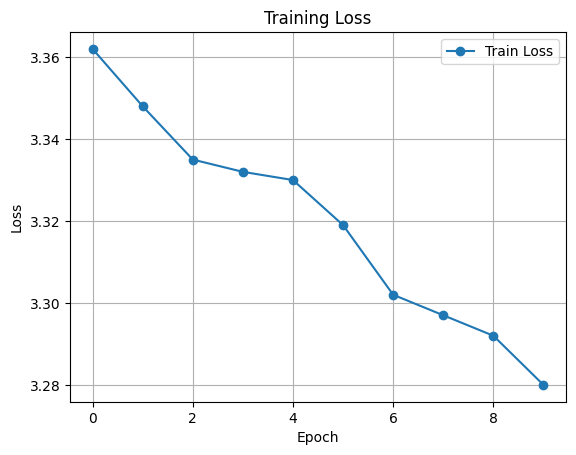

In [ ]:
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Как видно из графика ошибки, на всём промежутке обучения есть улучшения, однако они небольшие.

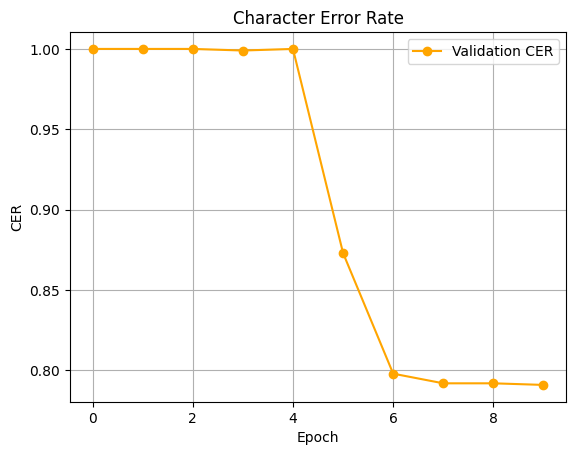

In [ ]:
plt.plot(val_cer_scores, label='Validation CER', color='orange', marker='o')
plt.title('Character Error Rate')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.grid(True)
plt.legend()
plt.show()

Как видно из графика CER, вначале модель стопорится, однако потом метрика сильно улучшается.

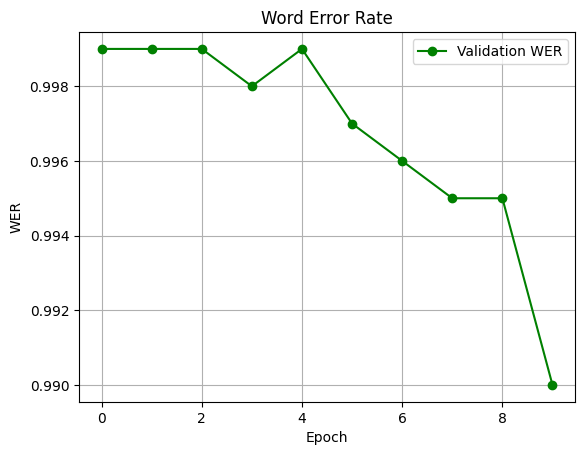

In [ ]:
plt.plot(val_wer_scores, label='Validation WER', color='green', marker='o')
plt.title('Word Error Rate')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.grid(True)
plt.legend()
plt.show()

Из графика WER видно, что метрика колеблется вокруг значений 0,9985 и 0,99, что показывает, что модель лучше предыдущей, однако всё равно требуется улучшение.

Базовая seq2seq с GRU

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        outputs = self.dropout(outputs)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

Запускаем обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = Encoder(vocab_size, 256, 512).to(device)
dec = Decoder(vocab_size, 256, 512).to(device)
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()))
criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx['<PAD>'])

N_EPOCHS = 10
CLIP = 1.0
train_losses = []
val_cer_scores = []
val_wer_scores = []

for epoch in range(N_EPOCHS):
    train_loss = train((enc, dec), train_loader, optimizer, criterion, CLIP)
    val_cer, val_wer = evaluate((enc, dec), val_loader, criterion)

    train_losses.append(train_loss)
    val_cer_scores.append(val_cer)
    val_wer_scores.append(val_wer)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val CER: {val_cer:.3f} | Val WER: {val_wer:.3f}')

Epoch: 01 | Train Loss: 3.358 | Val CER: 0.977 | Val WER: 0.997
Epoch: 02 | Train Loss: 3.278 | Val CER: 0.776 | Val WER: 0.992
Epoch: 03 | Train Loss: 3.228 | Val CER: 0.696 | Val WER: 0.989
Epoch: 04 | Train Loss: 3.200 | Val CER: 0.777 | Val WER: 0.991
Epoch: 05 | Train Loss: 3.187 | Val CER: 0.743 | Val WER: 0.987
Epoch: 06 | Train Loss: 3.169 | Val CER: 0.742 | Val WER: 0.988
Epoch: 07 | Train Loss: 3.159 | Val CER: 0.701 | Val WER: 0.987
Epoch: 08 | Train Loss: 3.152 | Val CER: 0.632 | Val WER: 0.983
Epoch: 09 | Train Loss: 3.150 | Val CER: 0.617 | Val WER: 0.988
Epoch: 10 | Train Loss: 3.142 | Val CER: 0.604 | Val WER: 0.982


Визуализируем результаты

In [ ]:
best_gru_loss = np.min(train_losses)
best_gru_cer = np.min(val_cer_scores)
best_gru_wer = np.min(val_wer_scores)

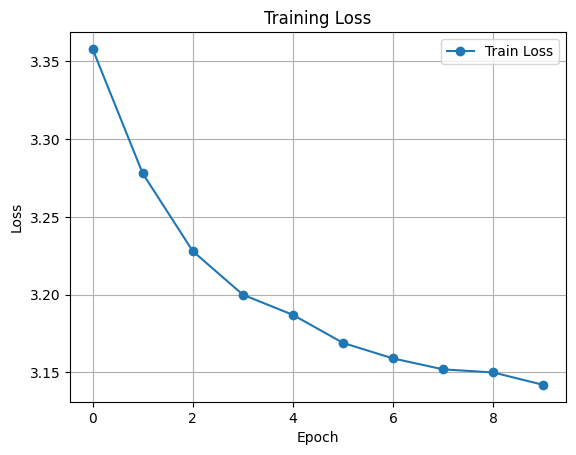

In [ ]:
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Из графика ошибки видно, что модель с GRU обучалась лучше чем с LSTM.

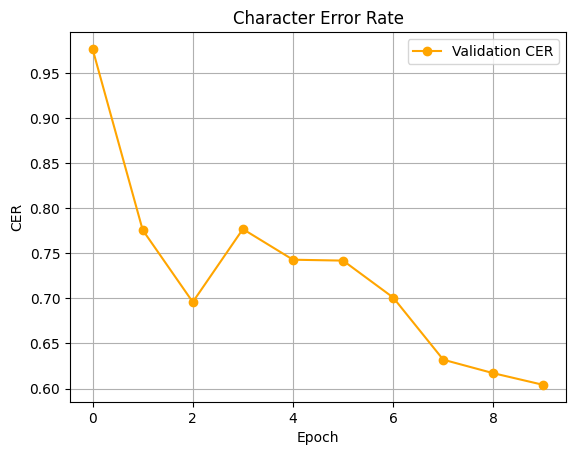

In [ ]:
plt.plot(val_cer_scores, label='Validation CER', color='orange', marker='o')
plt.title('Character Error Rate')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.grid(True)
plt.legend()
plt.show()

Из графика CER видно, что метрика потихоньку улучшается почти на всём промежутке обучения.

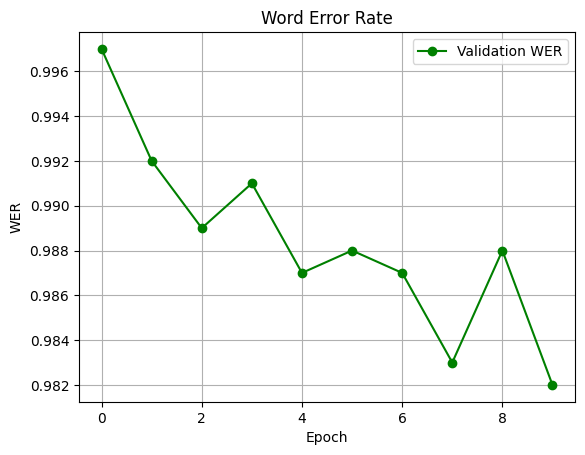

In [ ]:
plt.plot(val_wer_scores, label='Validation WER', color='green', marker='o')
plt.title('Word Error Rate')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.grid(True)
plt.legend()
plt.show()

Из графика WER видно, что метрика улучшается очень медленно, что говорит о том, что модель необходимо улучшить.

Из-за нехватки памяти пришось урезать датасет

In [ ]:
df = df.head(2000)

Базовая seq2seq с GRU с добавленным механизмом Attention

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hid_dim*2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        outputs = self.dropout(outputs)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1)))
        hidden = self.dropout(hidden)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim*2 + hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim*2, hid_dim, batch_first=True)
        self.attention = Attention(hid_dim)
        self.fc_out = nn.Linear(hid_dim*2 + emb_dim + hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        _, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        hidden = hidden.squeeze(0)
        output = self.fc_out(torch.cat((hidden, weighted.squeeze(1), embedded.squeeze(1)), dim=1))
        return output, hidden

пришлось чуть чуть изменить функии обучения и оценки

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    enc, dec = model
    enc.train()
    dec.train()
    epoch_loss = 0

    for src, trg in iterator:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        encoder_outputs, hidden = enc(src)

        output = trg[:, 0]
        loss = 0

        for t in range(1, trg.shape[1]):
            output, hidden = dec(output, hidden, encoder_outputs)
            loss += criterion(output, trg[:, t])
            output = trg[:, t] if random.random() < 0.5 else output.argmax(1)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(enc.parameters(), clip)
        torch.nn.utils.clip_grad_norm_(dec.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() / trg.shape[1]

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    enc, dec = model
    enc.eval()
    dec.eval()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for src, trg in iterator:
            src, trg = src.to(device), trg.to(device)
            encoder_outputs, hidden = enc(src)

            output = trg[:, 0]
            preds = []

            for t in range(1, trg.shape[1]):
                output, hidden = dec(output, hidden, encoder_outputs)
                preds.append(output.argmax(1).cpu())
                output = output.argmax(1)

            preds = torch.stack(preds, 1)
            all_preds.extend(preds)
            all_targets.extend(trg[:, 1:].cpu())

    pred_texts = [' '.join([idx_to_char[int(i)] for i in seq if i not in {0,1,2,3}]) for seq in all_preds]
    target_texts = [' '.join([idx_to_char[int(i)] for i in seq if i not in {0,1,2,3}]) for seq in all_targets]

    cer_score = cer(target_texts, pred_texts)
    wer_score = wer(target_texts, pred_texts)

    return cer_score, wer_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = Encoder(vocab_size, 128, 256).to(device)
dec = Decoder(vocab_size, 128, 256).to(device)
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()))
criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx['<PAD>'])

N_EPOCHS = 10
CLIP = 1.0
train_losses = []
val_cer_scores = []
val_wer_scores = []

for epoch in range(N_EPOCHS):
    train_loss = train((enc, dec), train_loader, optimizer, criterion, CLIP)
    val_cer, val_wer = evaluate((enc, dec), val_loader, criterion)

    train_losses.append(train_loss)
    val_cer_scores.append(val_cer)
    val_wer_scores.append(val_wer)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val CER: {val_cer:.3f} | Val WER: {val_wer:.3f}')

Epoch: 01 | Train Loss: 2.974 | Val CER: 0.616 | Val WER: 0.839
Epoch: 02 | Train Loss: 2.616 | Val CER: 0.606 | Val WER: 0.760
Epoch: 03 | Train Loss: 2.369 | Val CER: 0.531 | Val WER: 0.732
Epoch: 04 | Train Loss: 2.165 | Val CER: 0.487 | Val WER: 0.663
Epoch: 05 | Train Loss: 1.871 | Val CER: 0.475 | Val WER: 0.643
Epoch: 06 | Train Loss: 1.596 | Val CER: 0.431 | Val WER: 0.554
Epoch: 07 | Train Loss: 1.359 | Val CER: 0.419 | Val WER: 0.527
Epoch: 08 | Train Loss: 1.149 | Val CER: 0.445 | Val WER: 0.498
Epoch: 09 | Train Loss: 1.014 | Val CER: 0.457 | Val WER: 0.482
Epoch: 10 | Train Loss: 0.880 | Val CER: 0.450 | Val WER: 0.477


In [ ]:
N_EPOCHS = 10
CLIP = 1.0

for epoch in range(N_EPOCHS):
    train_loss = train((enc, dec), train_loader, optimizer, criterion, CLIP)
    val_cer, val_wer = evaluate((enc, dec), val_loader, criterion)

    train_losses.append(train_loss)
    val_cer_scores.append(val_cer)
    val_wer_scores.append(val_wer)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val CER: {val_cer:.3f} | Val WER: {val_wer:.3f}')

Epoch: 01 | Train Loss: 0.746 | Val CER: 0.446 | Val WER: 0.462
Epoch: 02 | Train Loss: 0.668 | Val CER: 0.434 | Val WER: 0.459
Epoch: 03 | Train Loss: 0.634 | Val CER: 0.403 | Val WER: 0.455
Epoch: 04 | Train Loss: 0.608 | Val CER: 0.427 | Val WER: 0.455
Epoch: 05 | Train Loss: 0.561 | Val CER: 0.446 | Val WER: 0.455
Epoch: 06 | Train Loss: 0.536 | Val CER: 0.434 | Val WER: 0.458
Epoch: 07 | Train Loss: 0.509 | Val CER: 0.448 | Val WER: 0.450
Epoch: 08 | Train Loss: 0.507 | Val CER: 0.447 | Val WER: 0.456
Epoch: 09 | Train Loss: 0.498 | Val CER: 0.435 | Val WER: 0.456
Epoch: 10 | Train Loss: 0.467 | Val CER: 0.439 | Val WER: 0.447


Визуализируем результаты

In [ ]:
best_att_loss = np.min(train_losses)
best_att_cer = np.min(val_cer_scores)
best_att_wer = np.min(val_wer_scores)

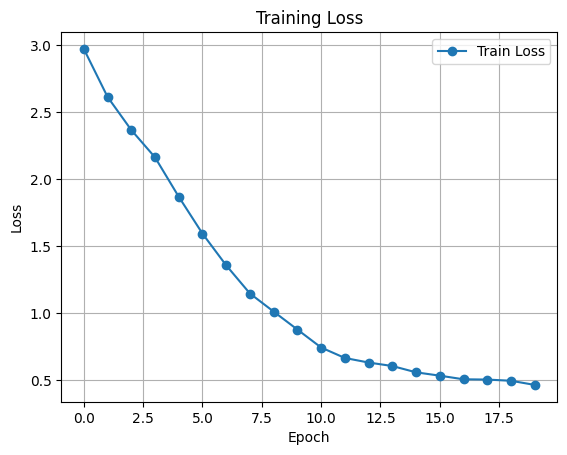

In [ ]:
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Из графика ошибки видно, что модель обучается хорошо и ошибка стабильно уменьшается

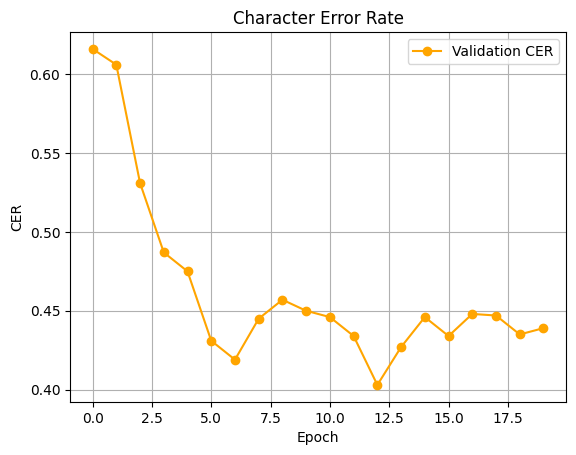

In [ ]:
plt.plot(val_cer_scores, label='Validation CER', color='orange', marker='o')
plt.title('Character Error Rate')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.grid(True)
plt.legend()
plt.show()

Из графика CER видно, что модель обучается неплохо, однако стопорится на значении метрики около 0, 425.

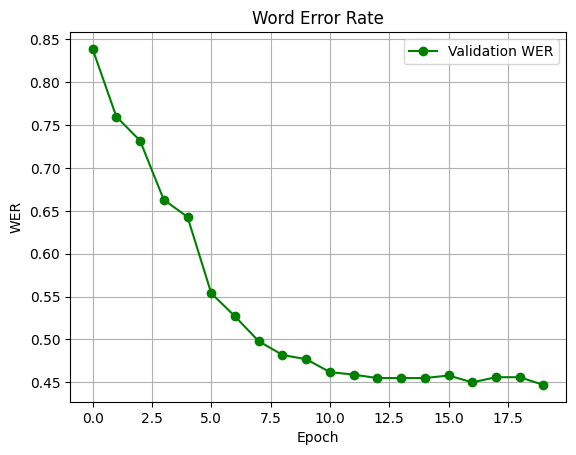

In [ ]:
plt.plot(val_wer_scores, label='Validation WER', color='green', marker='o')
plt.title('Word Error Rate')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.grid(True)
plt.legend()
plt.show()

График WER поначалу показывает стабильное улучшение метрики до значения 0,45, однако потом улучшения незначительные.

В качестве эталона была выбрана предобученная модель BERT

In [ ]:
from torch.optim import AdamW
from transformers import BertTokenizer, BertForMaskedLM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

в датасет была добавлена функция обработки данных (эмбеддинг)

In [ ]:
class DataFrameCorrectionDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.encodings = self._process_data(df['source'], df['correction'])

    def _process_data(self, originals, corrections):
        encodings = {'input_ids': [], 'attention_mask': [], 'labels': []}

        for orig, corr in zip(originals, corrections):
            orig_enc = self.tokenizer(
                str(orig),
                padding='max_length',
                truncation=True,
                max_length=self.max_length
            )
            corr_enc = self.tokenizer(
                str(corr),
                padding='max_length',
                truncation=True,
                max_length=self.max_length
            )

            mask = [1 if ot != ct else 0 for ot, ct in zip(orig_enc['input_ids'], corr_enc['input_ids'])]

            input_ids = []
            labels = []

            for o, c, m in zip(orig_enc['input_ids'], corr_enc['input_ids'], mask):
                if m:
                    input_ids.append(self.tokenizer.mask_token_id)
                    labels.append(c)
                else:
                    input_ids.append(o)
                    labels.append(-100)

            encodings['input_ids'].append(input_ids)
            encodings['attention_mask'].append(orig_enc['attention_mask'])
            encodings['labels'].append(labels)

        return encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

Из-за ограниченности вычислительной мощности было решено заморозть все слои модели кроме 4 последних

In [ ]:
def freeze_layers(model, num_unfrozen_layers=4):
    for param in model.parameters():
        param.requires_grad = False
    for layer in model.bert.encoder.layer[-num_unfrozen_layers:]:
        for param in layer.parameters():
            param.requires_grad = True
    for param in model.cls.parameters():
        param.requires_grad = True

Функия применения модели к тексту

In [ ]:
def correct_text_with_model(model, tokenizer, text, device='cuda'):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_ids = torch.argmax(outputs.logits, dim=-1)
    return tokenizer.decode(predicted_ids[0], skip_special_tokens=True)

Функция обучения

In [ ]:
def train_correction_model(df, model_save_path='bert_corrector', num_unfrozen_layers=4, test_size=0.2):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
    model = BertForMaskedLM.from_pretrained("bert-base-multilingual-cased")

    freeze_layers(model, num_unfrozen_layers)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,} ({trainable_params/total_params:.1%})")

    train_dataset = DataFrameCorrectionDataset(train_df, tokenizer)
    test_dataset = DataFrameCorrectionDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=3e-5)
    train_losses = []
    test_wers = []
    test_cers = []
    model.train()

    for epoch in range(10):
        epoch_loss = 0
        num_batches = 0
        train_loop = tqdm(train_loader, desc=f'Train Epoch {epoch}', leave=True)
        for batch in train_loop:
            optimizer.zero_grad()

            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1
            train_loop.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)

        test_predictions = []
        test_references = []

        model.eval()
        with torch.no_grad():
            for _, row in test_df.iterrows():
                corrected = correct_text_with_model(model, tokenizer, row['source'])
                test_predictions.append(corrected)
                test_references.append(row['correction'])

        filtered_data = [(ref, pred) for ref, pred in zip(test_references, test_predictions) if ref != ""]

        test_references, test_predictions = zip(*filtered_data)
        test_references = list(test_references)
        test_predictions = list(test_predictions)

        test_wer = wer(test_references, test_predictions)
        test_cer = cer(test_references, test_predictions)

        test_wers.append(test_wer)
        test_cers.append(test_cer)

    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)


    metrics = (train_losses, test_wers, test_cers)

    return model, tokenizer, optimizer, test_df, metrics

trained_model, trained_tokenizer, trained_optimizer, test_df, metrics = train_correction_model(df)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Всего параметров: 177,974,523
Обучаемых параметров: 120,875,259 (67.9%)


Train Epoch 9: 100%|██████████| 1169/1169 [06:29<00:00,  3.00it/s, loss=1.7]


Визуализируем результаты

In [ ]:
train_losses, val_cer_scores, val_wer_scores = metrics

In [ ]:
best_tl_loss = np.min(train_losses)
best_tl_cer = np.min(val_cer_scores)
best_tl_wer = np.min(val_wer_scores)

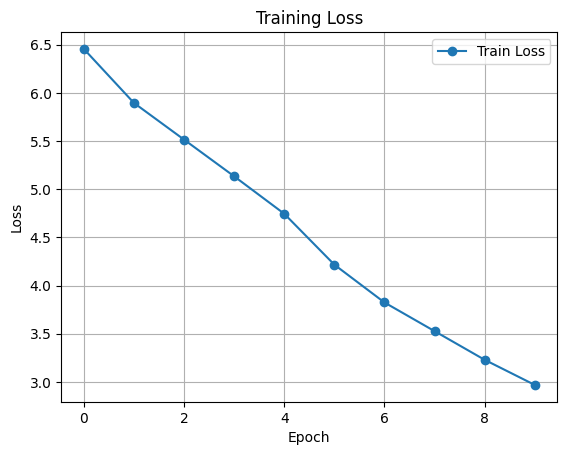

In [ ]:
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

График ошибки показывает, что модель обучалась хорошо на всём промежутке.

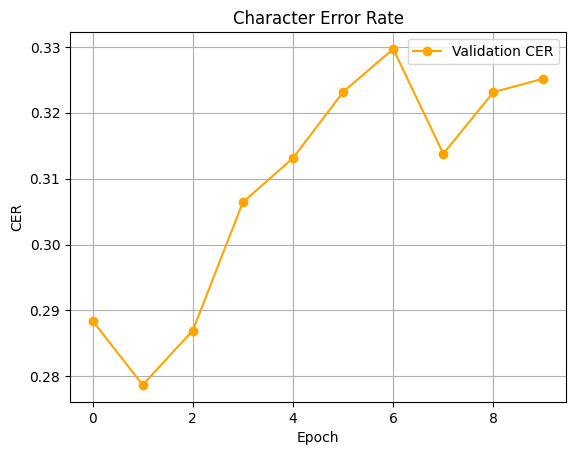

In [ ]:
plt.plot(val_cer_scores, label='Validation CER', color='orange', marker='o')
plt.title('Character Error Rate')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.grid(True)
plt.legend()
plt.show()

График CER показывает, что метрика росла по мере обучения, скорее всего это связано с тем, что предобученная модель сама по себе хорошо справляется с задачей. Наилучшее значение метрики было примерно 0,28, что является хорошим значением.

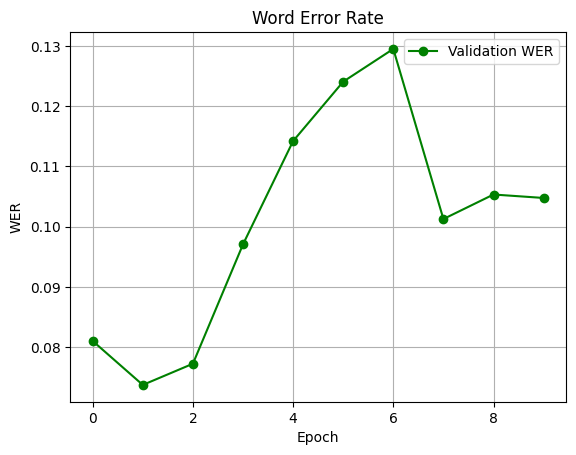

In [ ]:
plt.plot(val_wer_scores, label='Validation WER', color='green', marker='o')
plt.title('Word Error Rate')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.grid(True)
plt.legend()
plt.show()

График WER практически идентичен графике CER, однако наилучшее значение метрики является 0,07, что просто прекрасно. Значит предобученная модель справляется с задачей.

Создадим сравнительную таблицу всех моделей

In [ ]:
results = {

    "Модель с RNN": [best_rnn_loss, best_rnn_cer, best_rnn_wer],
    "Модель с LSTM": [best_lstm_loss, best_lstm_cer, best_lstm_wer],
    "Модель с GRU": [best_gru_loss, best_gru_cer, best_gru_wer],
    "Модель с GRU и Attention": [best_att_loss, best_att_cer, best_att_wer],
    "Предобученная модель": [best_tl_loss, best_tl_cer, best_tl_wer]
}

In [ ]:
results = pd.DataFrame.from_dict(results, orient='index', columns=['Loss', 'CER', 'WER'])
results

,Loss,CER,WER
Модель с RNN,3.650,0.999,0.998
Модель с LSTM,3.280,0.791,0.990
Модель с GRU,3.142,0.604,0.982
Модель с GRU и Attention,0.880,0.419,0.477
Предобученная модель,2.980,0.273,0.072


Из данной таблицы видно, что без механизма внимания, наилучшей моделей является модель с GRU, которая сильно улучшилась после добавления механизма внимания, а наилучшей моделью оказалась предобученная модель